# Random Forests

Random forests are an ensemble learning method that can be used for
classification or regression by constructing several individual 
decision trees as opposed to just one. 

For classification:

- Each decision tree in the forest gives a class prediction, and whichever class is selected most often is the output of the random forest.

For regression:

- The output of the random forest is the average prediction of the individual trees.

Advantages of Random Forests:

- Reduces overfitting that sometimes occurs in decision trees and improves accuracy
- Can handle large datasets as well as missing data
- Can perform both classification and regression tasks
- Produces good predictions that can be easily understood

Disadvantages of Random Forests:

- Requires more computational power and resources
- Consumes more time compared to a decision tree algorithm

## Installing Packages

To utilize random forests in Python, we first need to install the `scikit-learn` package.

- pip: `pip install scikit-learn`
- conda: `conda install scikit-learn`

We'll also want to install the `graphviz` package to improve the visualizations, which can be 
done using `conda install python-graphviz`.

## Simple Example

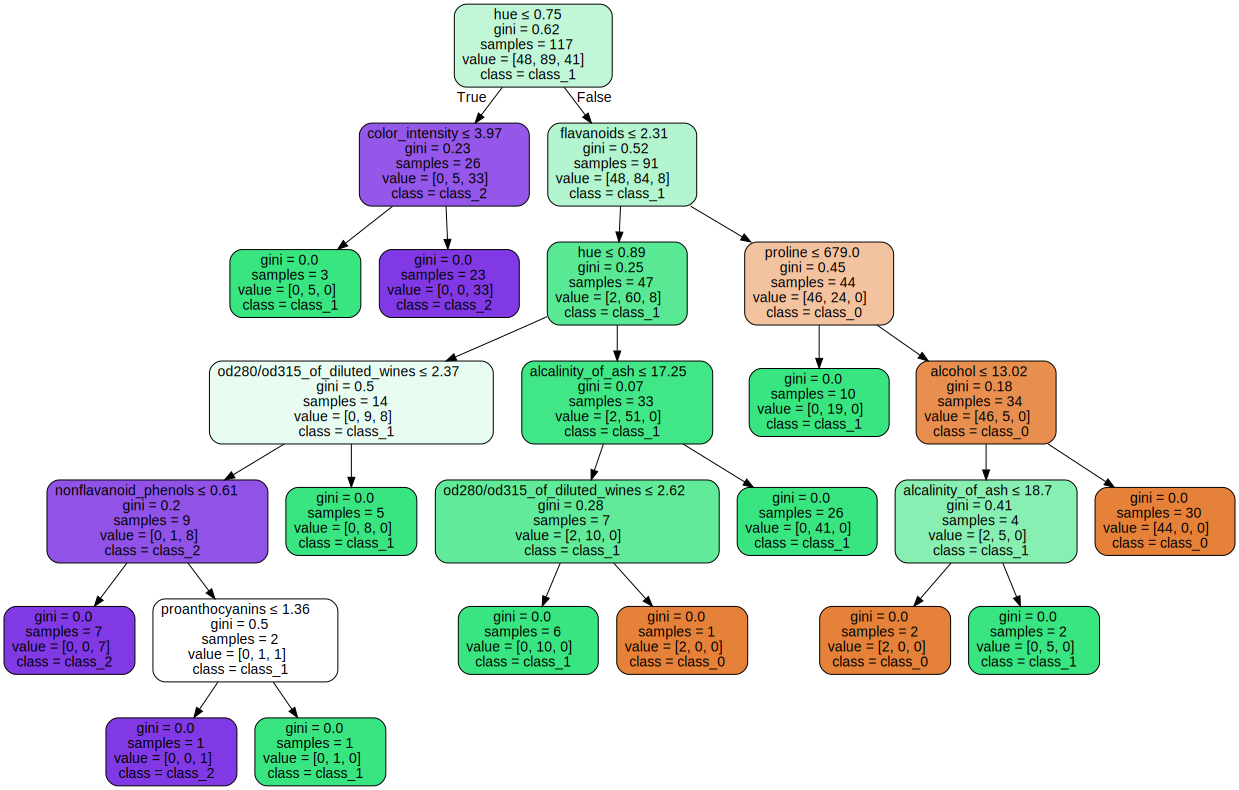

In [1]:
## Configure the inline figures to svg format
%config InlineBackend.figure_formats = ['svg']

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import export_graphviz
import graphviz

wine = load_wine()
X, y = wine.data, wine.target
## Build a random forest with 50 trees in it
clf = RandomForestClassifier(n_estimators = 50, random_state = 99)
clf = clf.fit(X, y)

## Select a single tree from the forest to visualize
estimator = clf.estimators_[5]
dot_data = tree.export_graphviz(estimator, out_file = None, 
                                feature_names = wine.feature_names,  
                                class_names = wine.target_names,
                                filled = True, rounded = True,  
                                proportion = False, precision = 2, 
                                special_characters=True)

# Draw graph
graph = graphviz.Source(dot_data, format = "svg") 
graph

## Random Forest for Classification Using NYC Crash Data

Using the NYC Motor Vehicle Crash data, we'll create a random forest model in order to try and 
predict whether a crash results in an injury and/or death to any person. Before fitting the model 
however, we first need to decide which features we'll want to include in our model. For this example, 
we'll include the following features and outcome variable to predict:

- `injured_dead_status` (outcome): indicates whether at least person was injured or killed in a crash (1 = yes, 0 = no)
- `timeframe`: the time of day in which the crash occured, split into 6-hour intervals over 24 hours
- (1 = 12AM-5:59AM, 2 = 6AM-11:59AM, 3 = 12PM-5:59PM, 4 = 6PM-11:59PM)
- `borough`: which borough the crash took place in
- `num_vehicles_involved`: number of vehicles involved in a crash
- `time_of_week`: day of week of the crash, which we'll split into weekdays and weekends

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

## Read in NYC crash data
nyc_crash = pd.read_csv("../data/nyc_mv_collisions_202201.csv")

In [3]:
## Create new variables relating to people injured and/or killed
## in a crash
nyc_crash['num_injured_dead'] = nyc_crash.apply(lambda row: 
                                                   row['NUMBER OF PERSONS KILLED'] +
                                                   row['NUMBER OF PERSONS INJURED'],
                                                   axis = 1)

nyc_crash['injured_dead_status'] = nyc_crash.apply(lambda row:
                                                   1 if row['num_injured_dead'] > 0
                                                   else 0, axis = 1)

nyc_crash['injured_dead_status'] = nyc_crash['injured_dead_status'].astype('category')

In [4]:
## Split crash times by hour
nyc_crash["hour"] = [x.split(":")[0] for x in nyc_crash["CRASH TIME"]]
nyc_crash["hour"] = [int(x) for x in nyc_crash["hour"]]

def timeframes(x):
    if x <= 5:
        return 1
    elif x > 5 and x <= 11:
        return 2
    elif x > 11 and x <= 17:
        return 3
    else:
        return 4

## Take crash hours and put them into specifc intervals
nyc_crash['timeframe'] = nyc_crash['hour'].apply(timeframes)
nyc_crash['timeframe'] = nyc_crash['timeframe'].astype('category')

contributing_factors = ['CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2',
                        'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4',
                        'CONTRIBUTING FACTOR VEHICLE 5']

## Number of vehicles involved in any crash
nyc_crash['num_vehicles_involved'] = len(nyc_crash[contributing_factors].columns) - nyc_crash[
                                         contributing_factors].isnull().sum(axis = 1)

In [5]:
## Convert 'CRASH DATE' to datetime format
nyc_crash['CRASH DATE'] = nyc_crash['CRASH DATE'].astype('datetime64[ns]')

## Column to indicate day of the week
nyc_crash['day_of_week'] = nyc_crash['CRASH DATE'].dt.day_name()

def is_weekend(x):
    if x == 'Saturday' or x == 'Sunday':
        return 'weekend'
    else:
        return 'weekday'
    
## Categorize days of week to weekday or weekend  
nyc_crash['time_of_week'] = nyc_crash['day_of_week'].apply(is_weekend)
nyc_crash.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,num_injured_dead,injured_dead_status,hour,timeframe,num_vehicles_involved,day_of_week,time_of_week
0,2022-01-01,7:05,NaN,NaN,NaN,NaN,NaN,EAST 128 STREET,3 AVENUE BRIDGE,NaN,...,NaN,NaN,NaN,0,0,7,2,1,Saturday,weekend
1,2022-01-01,14:43,NaN,NaN,40.769993,-73.915825,"(40.769993, -73.915825)",GRAND CENTRAL PKWY,NaN,NaN,...,NaN,NaN,NaN,0,0,14,3,1,Saturday,weekend
2,2022-01-01,21:20,QUEENS,11414.0,40.657230,-73.841380,"(40.65723, -73.84138)",91 STREET,160 AVENUE,NaN,...,NaN,NaN,NaN,0,0,21,4,1,Saturday,weekend
3,2022-01-01,4:30,NaN,NaN,NaN,NaN,NaN,Southern parkway,Jfk expressway,NaN,...,NaN,NaN,NaN,0,0,4,1,2,Saturday,weekend
4,2022-01-01,7:57,NaN,NaN,NaN,NaN,NaN,WESTCHESTER AVENUE,SHERIDAN EXPRESSWAY,NaN,...,NaN,NaN,NaN,0,0,7,2,1,Saturday,weekend


In [6]:
nyc_crash.rename(columns = {'BOROUGH': 'borough'}, inplace = True)
features = nyc_crash[['borough', 'timeframe', 'num_vehicles_involved', 'time_of_week']]

We now have all of the features we want to include in our model. Before we set up our 
random forest, we'll want to take our caterogical features and transform them into binary 
data for each category without any arbitrary ordering, a process known as one-hot encoding 
of data. This can be done very easily in pandas using the `pd.get_dummies()` function, where 
we pass in our features of interest.

In [7]:
labels = np.array(nyc_crash['injured_dead_status'])
features = pd.get_dummies(features)
features.head()

,num_vehicles_involved,borough_BRONX,borough_BROOKLYN,borough_MANHATTAN,borough_QUEENS,borough_STATEN ISLAND,timeframe_1,timeframe_2,timeframe_3,timeframe_4,time_of_week_weekday,time_of_week_weekend
0,1,0,0,0,0,0,0,1,0,0,0,1
1,1,0,0,0,0,0,0,0,1,0,0,1
2,1,0,0,0,1,0,0,0,0,1,0,1
3,2,0,0,0,0,0,1,0,0,0,0,1
4,1,0,0,0,0,0,0,1,0,0,0,1


Now our categorical features have seperate columns with binary values for each category. 
For example, the `borough` variable now has five seperate columns with either a 1 or 0 for 
each observation, for each borough. Now we can begin building our random forest model.

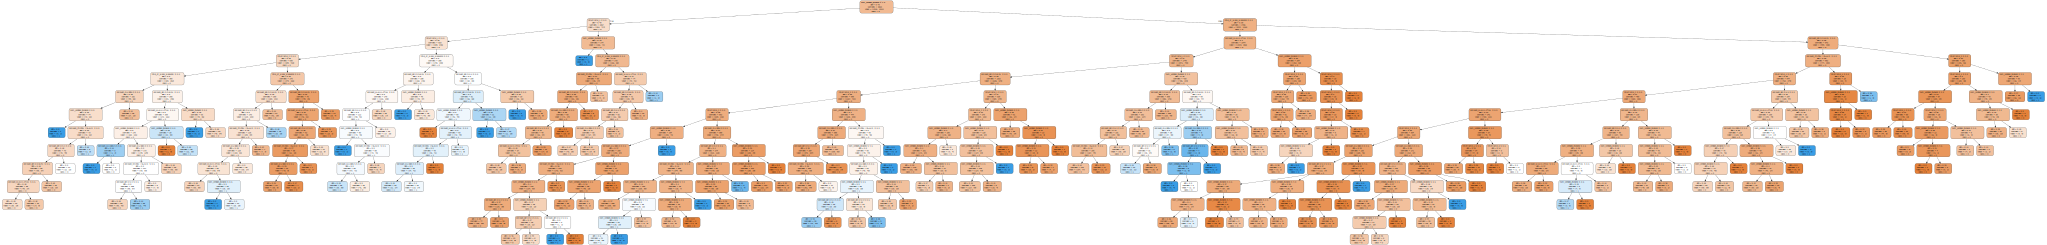

In [8]:
## start building random forest model:
x_train, x_test, y_train, y_test = train_test_split(features, labels, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

rfclf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfclf = rfclf.fit(x_train, y_train)

# Extract a single tree from the random forest
estimator = rfclf.estimators_[33]
dot_data = tree.export_graphviz(estimator, out_file = None, 
                                feature_names = features.columns,  
                                class_names = ['0', '1'],
                                filled = True, rounded = True,  
                                proportion = False, precision = 2, 
                                special_characters=True)
# Draw graph
graph = graphviz.Source(dot_data, format = "svg") 
graph

This individual decision tree that we selected from the random forest is quite large, with many 
splits occuring from the top node. If we count the number of levels, we can see that this tree 
has a depth of 13 before reaching the bottom. For this particular tree, the initial node splits 
on the `num_vehicles_involved` variable being less than or equal to 1.5 cars. 

Many of these trees are going to look different, and some might suffer from overfitting or be very 
inaccurate, but overall the classification returned by the majority of the decision trees is likely 
to be the most accurate. We can check the accuracy of our random forest model using our test data by 
using `scikit-learn`'s `accuracy_score()` and `confusion_matrix()` functions. 

We can also limit the depth of our random forest's trees by passing in the `max_depth` parameter in 
the random forest classifier, so that it's easier to visualize the tree.

In [9]:
y_pred = rfclf.predict(x_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7003916449086162
[[1041   41]
 [ 418   32]]


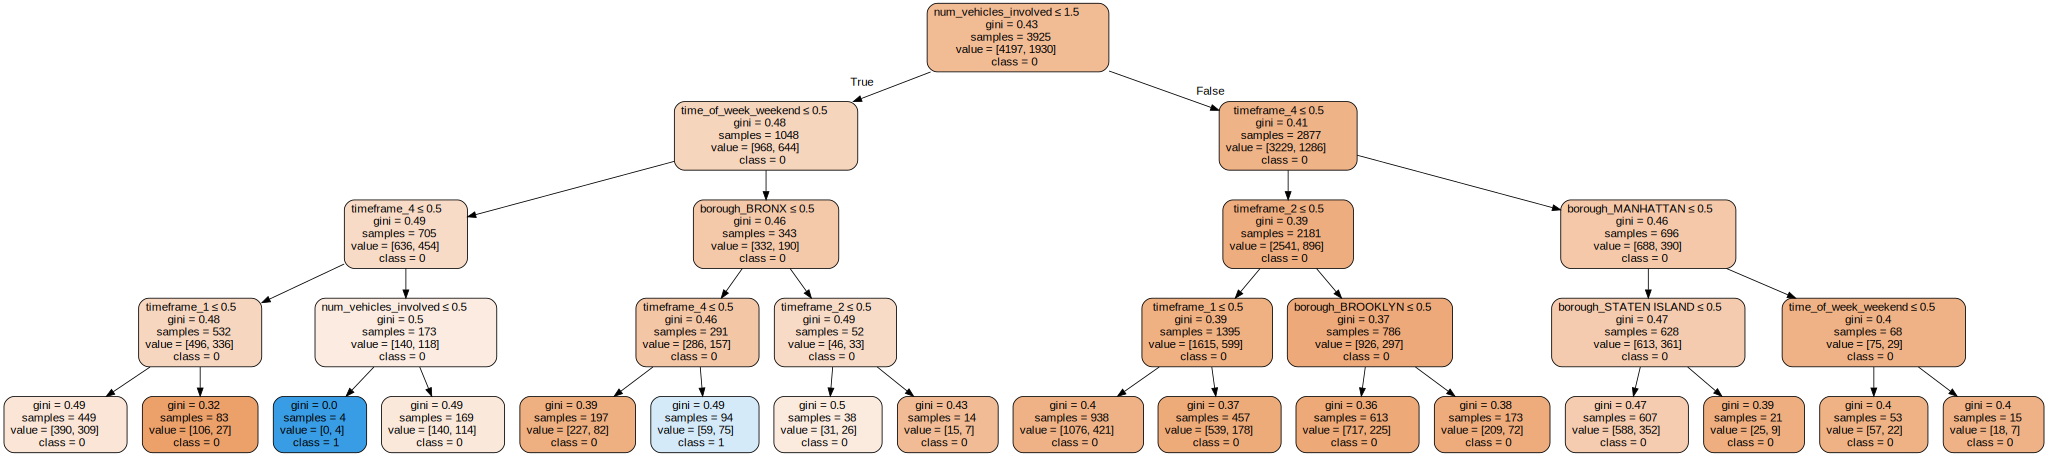

In [10]:
rfclf2 = RandomForestClassifier(n_estimators = 100, random_state = 42, max_depth = 4)
rfclf2 = rfclf2.fit(x_train, y_train)

# Extract a single tree from the random forest
estimator = rfclf2.estimators_[5]
dot_data = tree.export_graphviz(estimator, out_file = None, 
                                feature_names = features.columns,  
                                class_names = ['0', '1'],
                                filled = True, rounded = True,  
                                proportion = False, precision = 2, 
                                special_characters=True)
# Draw graph
graph = graphviz.Source(dot_data, format = "svg") 
graph

In [11]:
for i in range (1, 11):
    rfclf = RandomForestClassifier(n_estimators = 100, random_state = 42, max_depth = i)
    rfclf = rfclf.fit(x_train, y_train)
    y_pred = rfclf.predict(x_test)
    print("Accuracy for Forest with Max Depth {i}:".format(i = i), 
          metrics.accuracy_score(y_test, y_pred))

Accuracy for Forest with Max Depth 1: 0.706266318537859


Accuracy for Forest with Max Depth 2: 0.706266318537859


Accuracy for Forest with Max Depth 3: 0.706266318537859


Accuracy for Forest with Max Depth 4: 0.7095300261096605


Accuracy for Forest with Max Depth 5: 0.7095300261096605


Accuracy for Forest with Max Depth 6: 0.7095300261096605


Accuracy for Forest with Max Depth 7: 0.7056135770234987


Accuracy for Forest with Max Depth 8: 0.706266318537859


Accuracy for Forest with Max Depth 9: 0.7043080939947781


Accuracy for Forest with Max Depth 10: 0.7023498694516971


Looking at the depth for the trees in our random forest, it appears that the accuracy of our model 
is at its highest for trees with a depth between 4 and 6, with an accuracy of about 70.95%. We can
also see some other performance metrics using the `classifcation_report()` function in `sckiit-learn`.

In [12]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.97      0.82      1082
           1       0.46      0.07      0.12       450

    accuracy                           0.70      1532
   macro avg       0.58      0.52      0.47      1532
weighted avg       0.64      0.70      0.61      1532



We might also want to take a look at the importance of each of the different features our model
considered when splitting on different nodes. This can be done using the `feature_importances_`
attribute, which we can plot in a simple bar graph.

Text(0.5, 1.0, 'Importance of Each Feature')

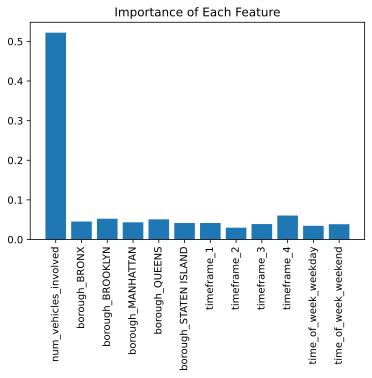

In [13]:
importances = rfclf.feature_importances_

plt.bar(features.columns, importances)
plt.xticks(rotation = 90)
plt.title('Importance of Each Feature')

## Random Forest Model for Regression

In [14]:
from sklearn.ensemble import RandomForestRegressor

In [15]:
labels2 = labels = np.array(nyc_crash['num_injured_dead'])

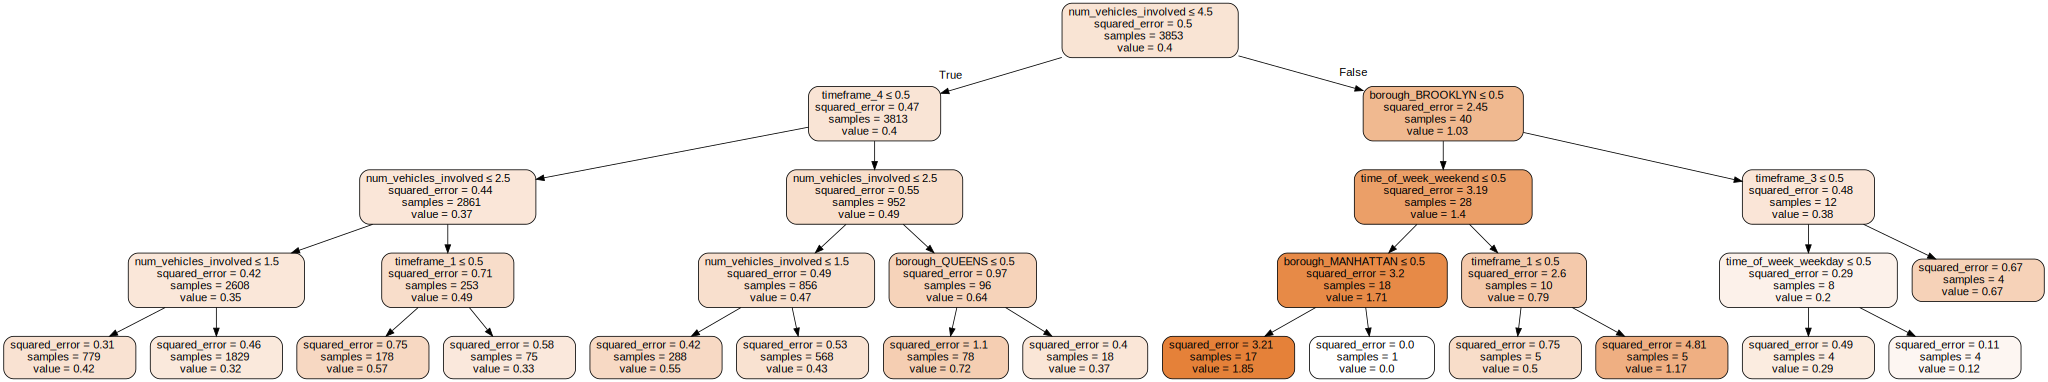

In [16]:
## start building random forest model:
x_train, x_test, y_train, y_test = train_test_split(features, labels2, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

rfclf = RandomForestRegressor(n_estimators = 100, random_state = 42, max_depth = 4)
rfclf = rfclf.fit(x_train, y_train)

# Extract a single tree from the random forest
estimator = rfclf.estimators_[33]
dot_data = tree.export_graphviz(estimator, out_file = None, 
                                feature_names = features.columns,  
                                class_names = None,
                                filled = True, rounded = True,  
                                proportion = False, precision = 2, 
                                special_characters=True)
# Draw graph
graph = graphviz.Source(dot_data, format = "svg") 
graph

In [17]:
y_pred = rfclf.predict(x_test)

df = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df["diff"] = abs(df["Actual"] - df["Predicted"])
df.sort_values(by = ['diff'], inplace = True)

print('Mean Absolute Error:', 
      metrics.mean_absolute_error(y_test, y_pred))

df.sort_values(by=['diff'], ascending=False,inplace=True)
df.head()

Mean Absolute Error: 0.5603409520733241


,Actual,Predicted,diff
1291,5,0.642135,4.357865
750,4,0.327590,3.672410
791,4,0.330216,3.669784
2,4,0.332213,3.667787
442,4,0.337047,3.662953


## Sources and Additional Information:

https://scikit-learn.org/stable/modules/ensemble.html#forest

https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c

https://www.section.io/engineering-education/introduction-to-random-forest-in-machine-learning/